In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx
import csv
import numpy as np
import sklearn
import seaborn as sns

In [3]:
census_bike = pd.read_csv('/content/drive/MyDrive/DS project/census_bike_merged.csv')

In [4]:
census_bike = census_bike.rename(columns={'renters_owners_ratio': 'owners_renters_ratio',
                            'renters_owners_pre-2000_ratio': 'owners_renters_pre-2000_ratio'} )

#Race

In [5]:
df = census_bike

columns = df.columns[[0,1,2] + list(range(7, 14))] # Add all race columns
df_race = df[list(columns)]
df_race

df_race_melt = pd.melt(df_race, id_vars=['year', 'tract', 'neighborhood'], var_name='race', value_name='percentage')
df_race_melt['tract'] = df_race_melt['tract'].astype('int').astype('object')
df_race_melt

,year,tract,neighborhood,race,percentage
0,2010,1001,Dorchester,race_white,0.063
1,2011,1001,Dorchester,race_white,0.109
2,2012,1001,Dorchester,race_white,0.074
3,2013,1001,Dorchester,race_white,0.112
4,2014,1001,Dorchester,race_white,0.131
...,...,...,...,...,...
4867,2009,923,Dorchester,race_hispanic,NaN
4868,2022,923,Dorchester,race_hispanic,NaN
4869,2008,924,Dorchester,race_hispanic,NaN
4870,2009,924,Dorchester,race_hispanic,NaN


In [6]:
def transform_race(value):
    if value == 'race_hispanic':
        return 'ethnicity_hispanic'
    elif value == 'race_white':
        return 'white'
    else:
        return 'non_white'

# Apply the transformation to the 'race' column
df_race_melt['race_2'] = df_race_melt['race'].apply(transform_race)
df_race_melt

,year,tract,neighborhood,race,percentage,race_2
0,2010,1001,Dorchester,race_white,0.063,white
1,2011,1001,Dorchester,race_white,0.109,white
2,2012,1001,Dorchester,race_white,0.074,white
3,2013,1001,Dorchester,race_white,0.112,white
4,2014,1001,Dorchester,race_white,0.131,white
...,...,...,...,...,...,...
4867,2009,923,Dorchester,race_hispanic,NaN,ethnicity_hispanic
4868,2022,923,Dorchester,race_hispanic,NaN,ethnicity_hispanic
4869,2008,924,Dorchester,race_hispanic,NaN,ethnicity_hispanic
4870,2009,924,Dorchester,race_hispanic,NaN,ethnicity_hispanic


In [7]:
df_race_melt[((df_race_melt['race_2']== 'non_white') |(df_race_melt['race_2']== 'white'))
                    & (df_race_melt['year']== 2010)].race_2.unique()

array(['white', 'non_white'], dtype=object)

<ipython-input-40-0fdd4b475c22>:6: UserWarning: The palette list has more values (8) than needed (2), which may not be intended.
  cat_plot = sns.catplot(data=df_race_melt[((df_race_melt['race_2']== 'non_white') |(df_race_melt['race_2']== 'white'))
<ipython-input-40-0fdd4b475c22>:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  for handle, label in zip(cat_plot._legend.legendHandles, cat_plot._legend.get_texts()):


<Figure size 1800x400 with 0 Axes>

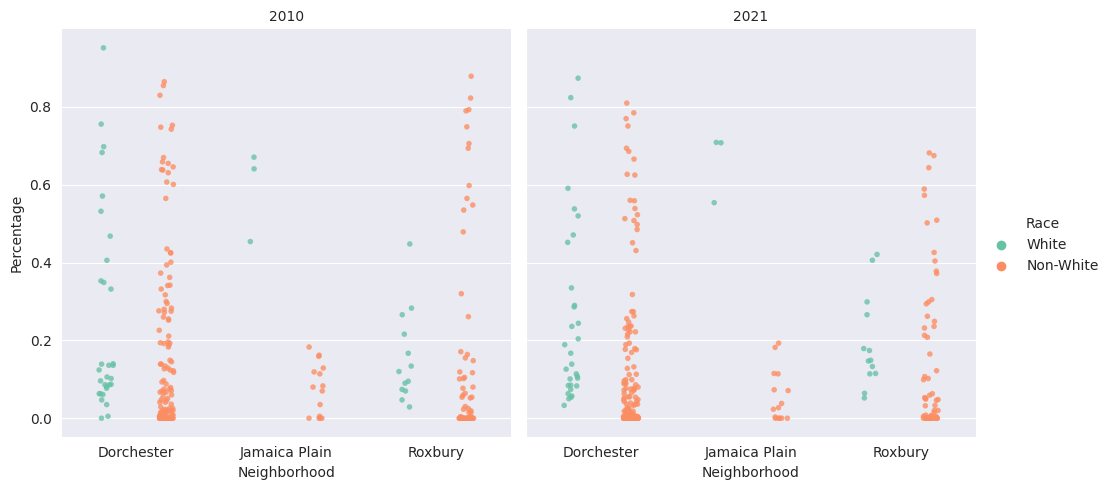

In [40]:
sns.set_style('darkgrid')
#custom_palette = [ "#33a02c", "#1f78b4", "#ff7f00"]
custom_palette = sns.color_palette("Set2")
plt.figure(figsize=(18, 4))

cat_plot = sns.catplot(data=df_race_melt[((df_race_melt['race_2']== 'non_white') |(df_race_melt['race_2']== 'white'))
                   &( (df_race_melt['year']== 2010)|(df_race_melt['year']== 2021) )],
                        x="neighborhood", y="percentage", hue="race_2", dodge=True,
                        palette = custom_palette, col='year', size=4, alpha =0.78)

cat_plot.set_axis_labels("Neighborhood", "Percentage")  # Modify x-axis and y-axis labels
cat_plot.set_titles(col_template="{col_name}", row_template="{row_name}")  # Show year as subplot titles

def customize_legend(ax, **kwargs):
    new_legend_labels = {'non_white': 'Non-White', 'white': 'White'}
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, [new_legend_labels[label] for label in labels], title="Race")

cat_plot.set_axis_labels("Neighborhood", "Percentage")  # Modify x-axis and y-axis labels
cat_plot.set_titles(col_template="{col_name}", row_template="{row_name}")  # Show year as subplot titles

cat_plot._legend.set_title("Race")
new_legend_labels = {'non_white': 'Non-White', 'white': 'White'}
for handle, label in zip(cat_plot._legend.legendHandles, cat_plot._legend.get_texts()):
    label.set_text(new_legend_labels[label.get_text()])
# Show the plots
plt.show()


* In this graph, each dot represents the percentage of each race in one census tract in a neigborhood. For example, in 2010, 1101 census tract in Jamaica Plain has 6 dots on the left graph, only one of which will be assigned to 'white' category.
* A comparison of race distribution (white VS non-white) among 3 neigborhoods shows that Jamaica Plain has the largest percentage-disparity between white population and the non-white, which includes'race_black', 'race_ai_alaskan', 'race_asian', 'race_hawaiian', & 'race_other' in original datasets. On the other hand, Roxbury's census tracts are typically associated with a low percentage of white population
* Between 2010 and 2021, all non-white population percentages decrease in general.

<Figure size 1300x600 with 0 Axes>

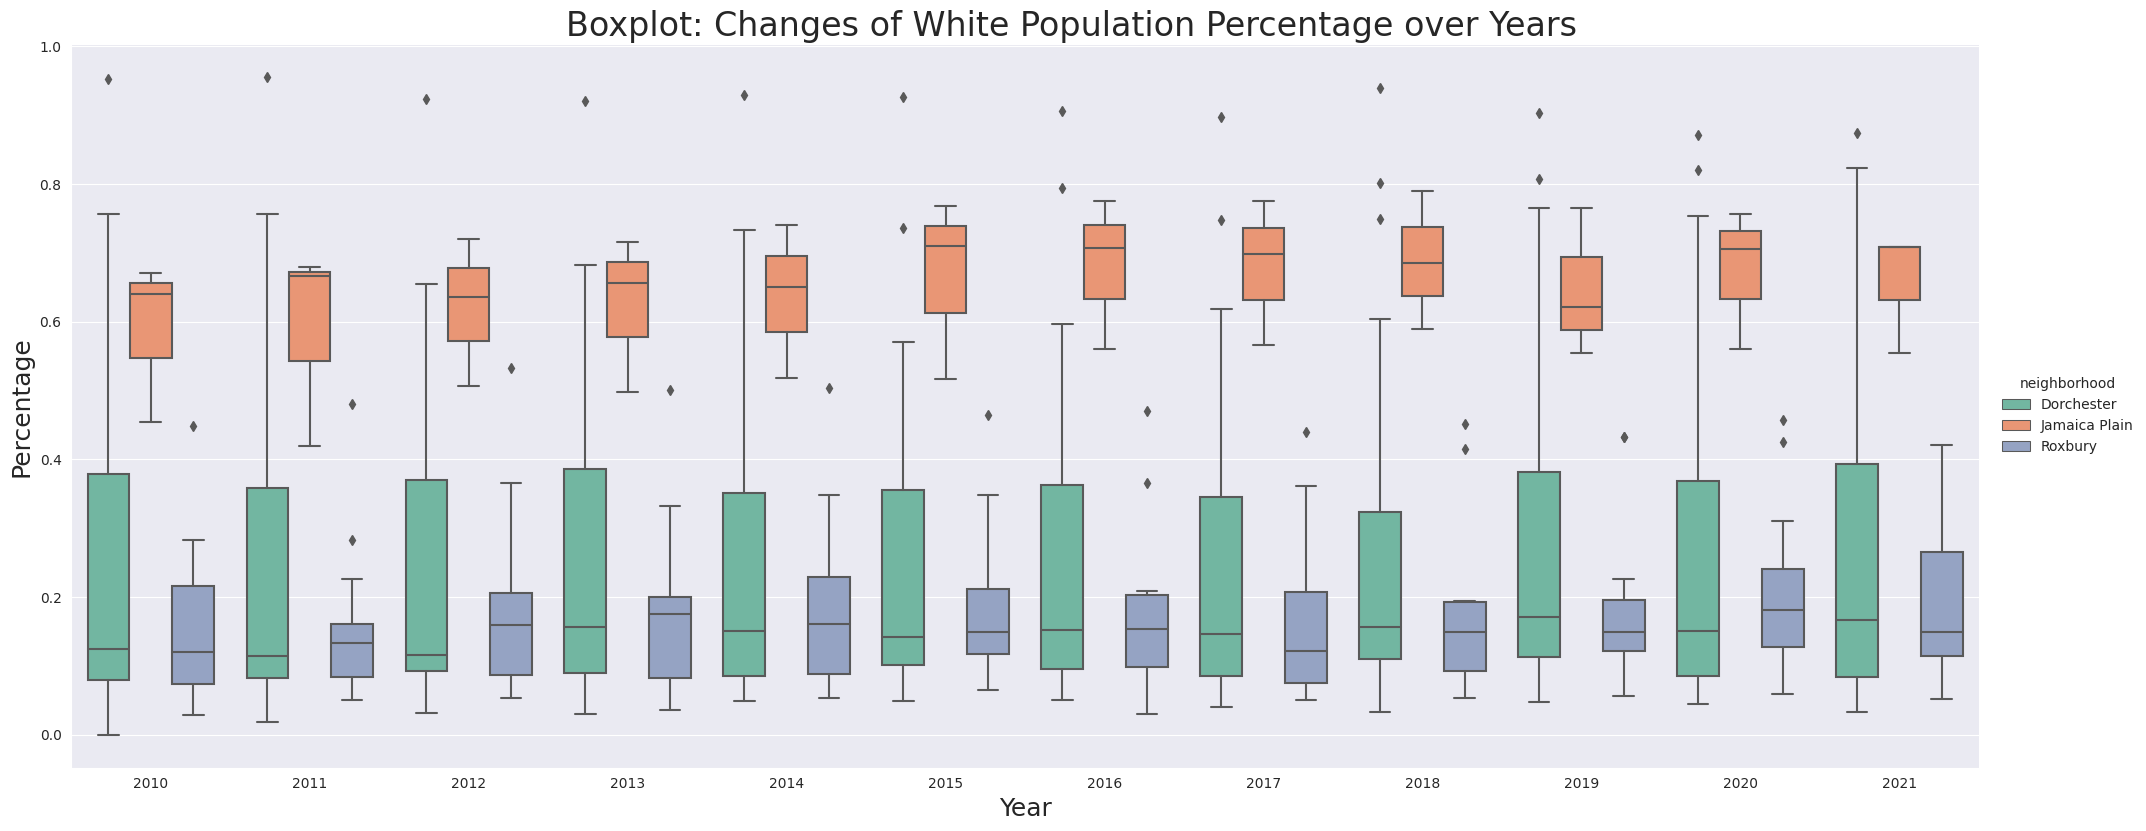

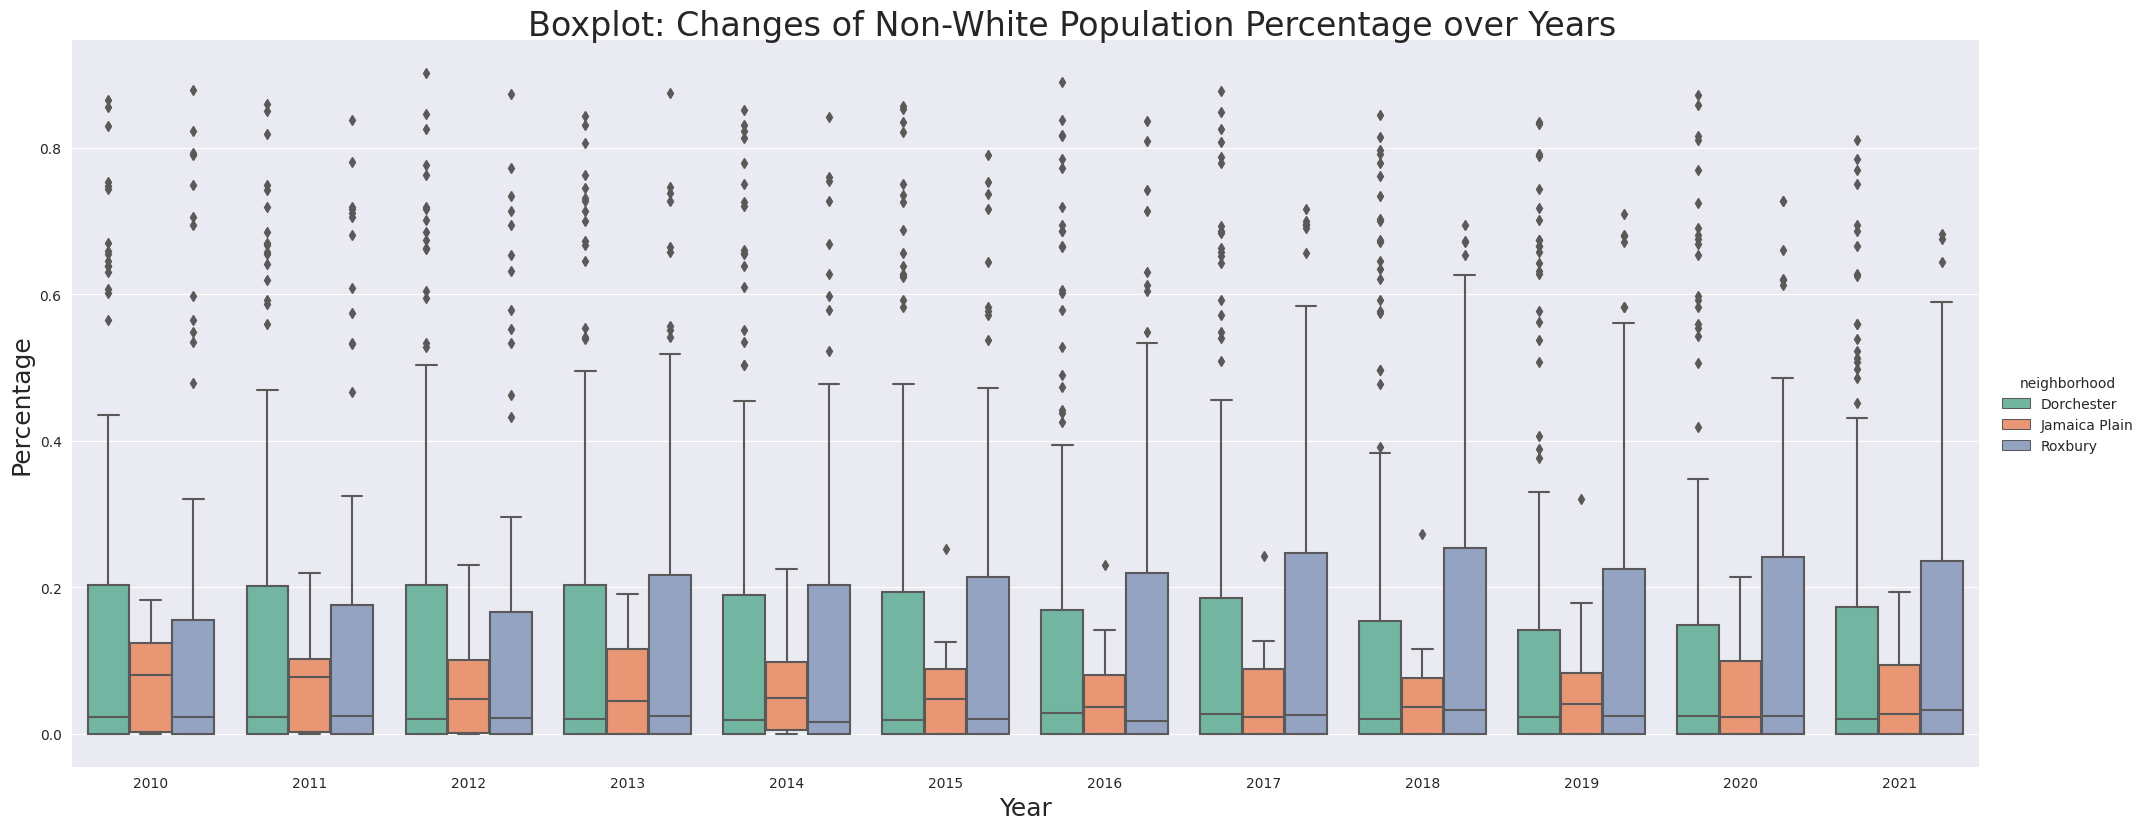

In [9]:
#custom_palette = [ "#33a02c", "#1f78b4", "#ff7f00"]
plt.figure(figsize=(13, 6))
g1 = sns.catplot(data=df_race_melt[(df_race_melt['race_2']=='white') & (df_race_melt['year'] >= 2010)
                               & (df_race_melt['year'] <= 2021)],
            x="year", y="percentage", hue="neighborhood",
            dodge=True, height = 8, aspect=2.5, kind='box',
            palette = custom_palette)

g1.fig.suptitle('Boxplot: Changes of White Population Percentage over Years', y=1.02, fontsize=24)
g1.set_xlabels("Year", fontsize=18)
g1.set_ylabels("Percentage", fontsize=18)


g2 = sns.catplot(data=df_race_melt[(df_race_melt['race_2']=='non_white') & (df_race_melt['year'] >= 2010)
                               & (df_race_melt['year'] <= 2021)],
            x="year", y="percentage", hue="neighborhood", dodge=True, height = 8, aspect=2.5, kind='box'
            , palette = custom_palette)

g2.fig.suptitle('Boxplot: Changes of Non-White Population Percentage over Years', y=1.02, fontsize=24)
g2.set_xlabels("Year", fontsize=18)
g2.set_ylabels("Percentage", fontsize=18)

# Houseownership

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.10980392156862745, 0.4980392156862745)) for an unfilled marker ('none').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.6941176470588235, 0.25098039215686274, 0.050980392156862744)) for an unfilled marker ('none').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.07058823529411765, 0.44313725490196076, 0.10980392156862745)) for an unfilled marker ('none').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may chan

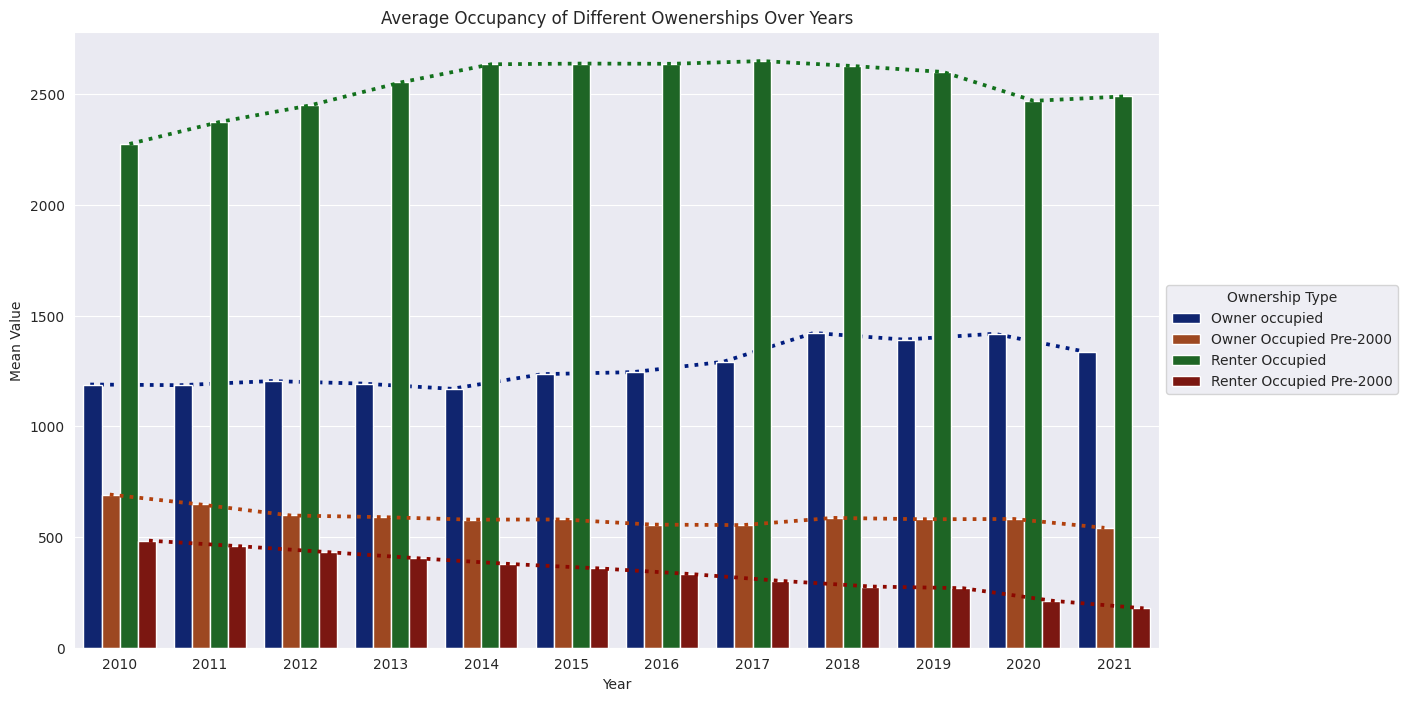

In [16]:
mean_by_year = df[(df['year'] >= 2010) & (df['year'] <= 2021)].groupby('year')[['owner_occupied', 'owner_occupied_pre-2000', 'renter_occupied', 'renter_occupied_pre-2000']].mean().reset_index()
mean_by_year_melted = mean_by_year.melt(id_vars='year', var_name='Ownership Type', value_name='Mean Value')

# Create a bar plot using seaborn
plt.figure(figsize=(14, 8))

custom_palette =  sns.set_palette('dark')

sns.pointplot(data=mean_by_year_melted, x='year', y='Mean Value',
              hue='Ownership Type', palette=custom_palette,
              linestyles=':', dodge =0.65, markers='none' )


bar_plot = sns.barplot(data=mean_by_year_melted, x='year', y='Mean Value',
            hue='Ownership Type', palette=custom_palette)


# Create a legend for the bar plot with unique categories
handles, labels = bar_plot.get_legend_handles_labels()
unique_categories = mean_by_year_melted['Ownership Type'].unique()
unique_handles = [handles[i] for i, label in enumerate(labels) if label in unique_categories][4:]
unique_labels = ['Owner occupied', 'Owner Occupied Pre-2000', 'Renter Occupied', 'Renter Occupied Pre-2000']


bar_plot.legend(title='Ownership Type', handles=unique_handles, labels=unique_labels,
                 bbox_to_anchor=(1, 0.5), loc='center left')


plt.title('Average Occupancy of Different Owenerships Over Years')
plt.xlabel('Year')
plt.ylabel('Mean Value')



plt.show()

* Even though there were both occupied renters and occupied owners that moved in before 2000, renters that moved in before 2000 decreased faster than the owner sector.

#Property

In [17]:
columns = df.columns[[0,1,2] + list(range(14, 17))] # Add all race columns
df_prop_val = df[list(columns)]

df_prop_val['monthly_rent_to_prop_val'] = df_prop_val['median_monthly_rent']/ df_prop_val['median_value']
df_prop_val['monthly_mort_to_prop_val'] = df_prop_val['median_monthly_mort']/ df_prop_val['median_value']
df_prop_val

df_prop_val_melt = pd.melt(df_prop_val, id_vars=['year', 'tract', 'neighborhood'], var_name='value_type', value_name='value')
df_prop_val_melt['tract'] = df_prop_val_melt['tract'].astype('int').astype('object')
df_prop_val_melt

<ipython-input-17-93e223167e94>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prop_val['monthly_rent_to_prop_val'] = df_prop_val['median_monthly_rent']/ df_prop_val['median_value']
<ipython-input-17-93e223167e94>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_prop_val['monthly_mort_to_prop_val'] = df_prop_val['median_monthly_mort']/ df_prop_val['median_value']


,year,tract,neighborhood,value_type,value
0,2010,1001,Dorchester,median_value,280400.0
1,2011,1001,Dorchester,median_value,276900.0
2,2012,1001,Dorchester,median_value,268000.0
3,2013,1001,Dorchester,median_value,261700.0
4,2014,1001,Dorchester,median_value,279300.0
...,...,...,...,...,...
3475,2009,923,Dorchester,monthly_mort_to_prop_val,NaN
3476,2022,923,Dorchester,monthly_mort_to_prop_val,NaN
3477,2008,924,Dorchester,monthly_mort_to_prop_val,NaN
3478,2009,924,Dorchester,monthly_mort_to_prop_val,NaN


/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.0, 0.10980392156862745, 0.4980392156862745)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.6941176470588235, 0.25098039215686274, 0.050980392156862744)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.07058823529411765, 0.44313725490196076, 0.10980392156862745)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the

Text(0.5, 1.0, 'Median Property Values in 3 Neigborhoods Over Years')

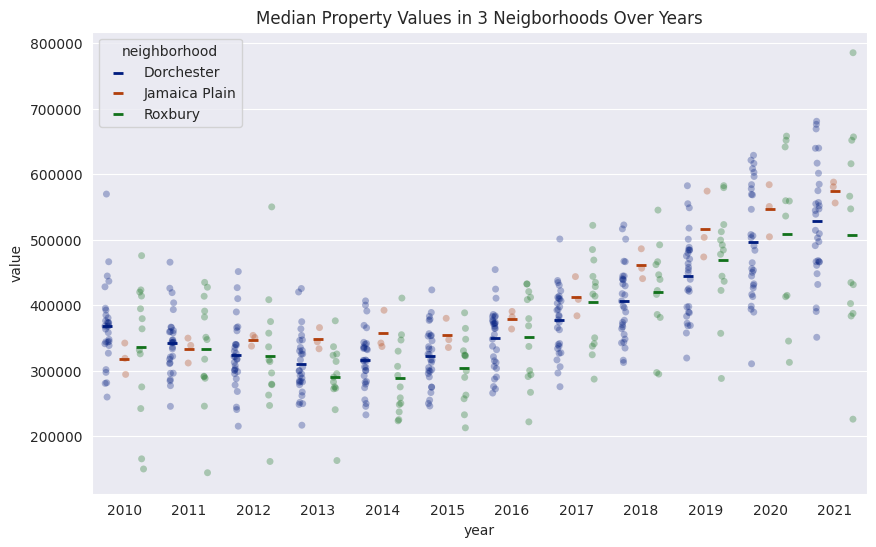

In [18]:
#Graph for Property Mean Value and Individual Observations
plt.figure(figsize=(10, 6))

sns.stripplot(
    data=df_prop_val_melt[(df_prop_val_melt['value_type'] == 'median_value')
                                         & (df_prop_val_melt['year'] >= 2010)
                                        & (df_prop_val_melt['year'] <= 2021)],
    x='year', y='value',
            hue='neighborhood',
    dodge=True, alpha=.3, legend=False,
)
sns.pointplot(
    data=df_prop_val_melt[(df_prop_val_melt['value_type'] == 'median_value')
                                         & (df_prop_val_melt['year'] >= 2010)
                                        & (df_prop_val_melt['year'] <= 2021)],
    x='year', y='value',
            hue='neighborhood',
    dodge=.53, linestyles="none", errorbar=None,
    markers="_"
)


plt.title('Median Property Values in 3 Neigborhoods Over Years')


* In 2010, we can see that the median proporty value in all three neighborhoods were at around 250,000. After that, property value in Jamaica Plain went on a steadily increasing trend, while Roxbury's and Dorchester's median property values decreased for a few years and also increased starting around 2015.

# Income

In [19]:
# creating corresponding dataframes for plotting
columns = df.columns[[0,1,2] + [17,18]] # Add all income columns
df_income = df[list(columns)]
df_income

df_income_melt = pd.melt(df_income, id_vars=['year', 'tract', 'neighborhood'], var_name='income_estimate_type', value_name='dollars')
df_income_melt['tract'] = df_income_melt['tract'].astype('int').astype('object')
df_income_melt

,year,tract,neighborhood,income_estimate_type,dollars
0,2010,1001,Dorchester,median_income,26007.0
1,2011,1001,Dorchester,median_income,22375.0
2,2012,1001,Dorchester,median_income,27840.0
3,2013,1001,Dorchester,median_income,24886.0
4,2014,1001,Dorchester,median_income,28671.0
...,...,...,...,...,...
1387,2009,923,Dorchester,mean_income,NaN
1388,2022,923,Dorchester,mean_income,NaN
1389,2008,924,Dorchester,mean_income,NaN
1390,2009,924,Dorchester,mean_income,NaN


<Axes: xlabel='year', ylabel='dollars'>

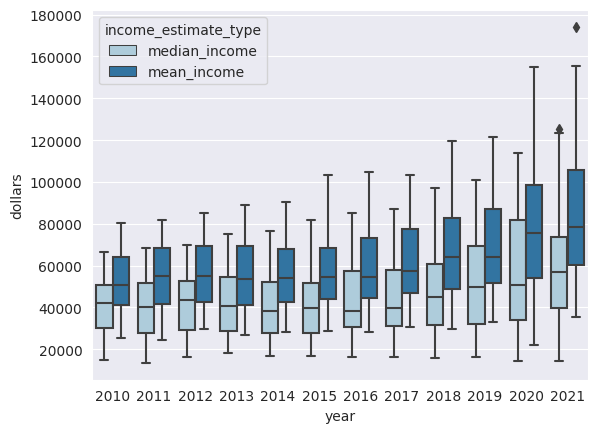

In [20]:
sns.boxplot(data= df_income_melt[(df_income_melt['year'] >= 2010) & (df_income_melt['year'] <= 2021) ],
  #& ((df_income_melt['value_type'] == 'median_monthly_mort') |
                               # (df_prop_val_melt['value_type'] == 'median_monthly_rent'))],
            x='year', y='dollars',
            hue='income_estimate_type', palette = sns.color_palette("Paired") )

* The above graph compares between the mean and median income for 3 neighborhood as an unity. Mean income and median did not differ a lot in 2010, as years passed, mean income was increasing faster than median, suggesting an increase of wealth(or income) inequality gap.

<Axes: xlabel='year', ylabel='dollars'>

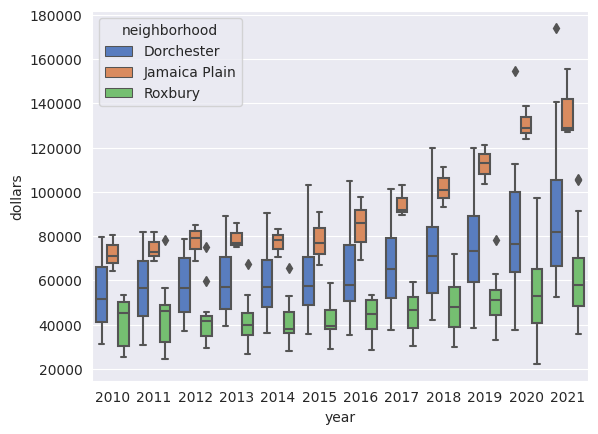

In [21]:
sns.boxplot(data= df_income_melt[(df_income_melt['year'] >= 2010)
          & (df_income_melt['year'] <= 2021)
        & (df_income_melt['income_estimate_type'] == 'mean_income')],
        x='year', y='dollars',hue='neighborhood', palette = sns.color_palette("muted") )

* Now we take a look at mean income separately. How the mean income value has evolved for these three neigborhood are quite different. The mean income in Jamacai Plain has noticably increased, while Roxbury's income has remained approximately the same(considering that this increase take inflation into account).

# Limitation and Future Scope

* Because of the original format of our datasets, we are not able to look at factors under a specific group. For example, when we analyze income in 3 neigborhood, we are not able to present the income distribution specifically across different races, but can only provide a neigborhood-level or census-tract-level perspective.

* Only 3 census tracts are used from Jamaica Plain